In [ ]:
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai # Make sure we have the latest fastai

#Please restart the runtime after this step, so fastai new version will be available

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 194kB 8.7MB/s 


In [ ]:
import fastai
print(fastai.__version__)
#it should be '2.0.15'

2.0.15


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage # TO avoid confusion later
from fastai.vision.all import *

In [ ]:
!gdown --id 1t5be8KLHOz3YuSmiiPQjopb4c_q2U4tG
!unzip olfactorydata.zip 
#thanks mmi333


Downloading...
From: https://drive.google.com/uc?id=1t5be8KLHOz3YuSmiiPQjopb4c_q2U4tG
To: /content/olfactorydata.zip
100% 94.3k/94.3k [00:00<00:00, 35.2MB/s]
Archive:  olfactorydata.zip
  inflating: train.csv               
  inflating: test.csv                
  inflating: sample_submission.csv   
  inflating: vocabulary.txt          


In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
vocabulary = open("vocabulary.txt").read()

In [ ]:
#Download images [256*256] i create with the help of "rdkit" 
!gdown --id 10zsdoTzY9tBqkXOyycSvfk1BGMXMIXnl
!gdown --id 1-1DzGTEezaTCTrUetClg-01P1VqSewbF

Downloading...
From: https://drive.google.com/uc?id=10zsdoTzY9tBqkXOyycSvfk1BGMXMIXnl
To: /content/train_imgs.zip
23.5MB [00:00, 27.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1DzGTEezaTCTrUetClg-01P1VqSewbF
To: /content/test_imgs.zip
5.96MB [00:00, 22.5MB/s]


In [ ]:
#unzip the file please gives correct path of zip images  
!unzip '/content/train_imgs.zip'
!unzip '/content/test_imgs.zip'


In [ ]:
train['imgs'] = [f"imgs/{i}.png" for i in range(len(train))]
test['imgs'] = [f"imgs_test/{i}.png" for i in range(len(test))]


In [ ]:
train.head(2)

SMILES               SENTENCE        imgs
0  C/C=C/C(=O)C1CCC(C=C1C)(C)C            fruity,rose  imgs/0.png
1                    COC(=O)OC  fresh,ethereal,fruity  imgs/1.png

In [ ]:
base_img_path = '/content/content/'
def get_x(r): return f'{base_img_path}{r["imgs"]}'
def get_y(r): return r['SENTENCE'].split(',')
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(train)
dsets.train[0]


(PILImage mode=RGB size=256x256,
 TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]))

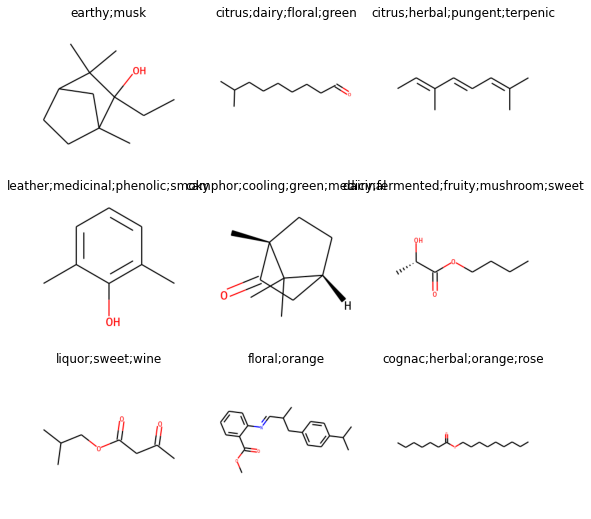

In [ ]:
# Create DataLoders
bs = 32
dls = dblock.dataloaders(train,bs = bs)
dls.show_batch()

In [ ]:
#To check gpu usages 
# !nvidia-smi

**Training**

In [ ]:
#different pretrained model
models = {
    "resnet18":resnet18,"resnet34":resnet34,"resnet50":resnet50,
    "resnet101":resnet101,
    "resnet152":resnet152,
    "densenet121":densenet121,
    "densenet161":densenet161,
    "densenet169":densenet169,"densenet201":densenet201,
    "vgg11_bn":vgg11_bn,"vgg13_bn":vgg13_bn,
    "vgg16_bn":vgg16_bn,"vgg19_bn":vgg19_bn
 }

 #Choose any model and trained your model how to it might improve the scrores 
 #but it take more time to train then other smaller models 

In [ ]:
learn = cnn_learner(dls, models["resnet34"], metrics=partial(accuracy_multi, thresh=0.9))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth




```
what is accuracy_mult:
it is metric which is used for multilabel classification
why because simple "accuracy" only compares one prediction with one target variable 
but here the problem is multilabel so we choose 
"accuracy_mult" metric to see model improvment

What is thresh parameter : 
it is the hyperparameter which can tweek to it ranges 
from [0 to 1] inclusively

```



**Prediction**

In [ ]:
#predictions
from tqdm import tqdm
preds = []
for i in tqdm(test['imgs'],total = len(test['imgs'])) :
  # Image.open(base_img_path+i)
  arr=learn.predict(base_img_path+i)[2]
  top_3 = np.argpartition(arr, -6)[-6:]
  top3_vocab = dls.train.vocab[top_3] 
  p = ''
  for l in top3_vocab:
    p = p  + l + ","
  # print(type(p),p)
  preds.append(p)


  0%|          | 0/1079 [00:00<?, ?it/s]

  0%|          | 3/1079 [00:00<00:41, 25.87it/s]

  1%|          | 7/1079 [00:00<00:39, 27.34it/s]

  1%|          | 11/1079 [00:00<00:37, 28.58it/s]

  1%|▏         | 15/1079 [00:00<00:35, 29.84it/s]

  2%|▏         | 19/1079 [00:00<00:34, 30.73it/s]

  2%|▏         | 23/1079 [00:00<00:33, 31.55it/s]

  3%|▎         | 27/1079 [00:00<00:33, 31.68it/s]

  3%|▎         | 31/1079 [00:00<00:32, 32.38it/s]

  3%|▎         | 35/1079 [00:01<00:32, 32.28it/s]

  4%|▎         | 39/1079 [00:01<00:32, 32.17it/s]

  4%|▍         | 43/1079 [00:01<00:32, 32.28it/s]

  4%|▍         | 47/1079 [00:01<00:31, 32.46it/s]

  5%|▍         | 51/1079 [00:01<00:31, 32.51it/s]

  5%|▌         | 55/1079 [00:01<00:31, 32.64it/s]

  5%|▌         | 59/1079 [00:01<00:31, 31.91it/s]

  6%|▌         | 63/1079 [00:01<00:32, 31.56it/s]

  6%|▌         | 67/1079 [00:02<00:32, 30.68it/s]

  7%|▋         | 71/1079 [00:02<00:33, 29.88it/s]

  7%|▋         | 75/1079 [00:02<00:33, 30.10it/s]

  7%|▋         | 79/1079 [00:02<00:33, 30.22it/s]

  8%|▊         | 83/1079 [00:02<00:32, 30.19it/s]

  8%|▊         | 87/1079 [00:02<00:32, 30.25it/s]

  8%|▊         | 91/1079 [00:02<00:32, 30.21it/s]

  9%|▉         | 95/1079 [00:03<00:33, 29.79it/s]

  9%|▉         | 99/1079 [00:03<00:32, 30.09it/s]

 10%|▉         | 103/1079 [00:03<00:33, 29.34it/s]

 10%|▉         | 106/1079 [00:03<00:33, 29.14it/s]

 10%|█         | 110/1079 [00:03<00:32, 29.68it/s]

 11%|█         | 114/1079 [00:03<00:31, 30.34it/s]

 11%|█         | 118/1079 [00:03<00:30, 31.34it/s]

 11%|█▏        | 122/1079 [00:03<00:29, 32.01it/s]

 12%|█▏        | 126/1079 [00:04<00:29, 32.52it/s]

 12%|█▏        | 130/1079 [00:04<00:29, 32.66it/s]

 12%|█▏        | 134/1079 [00:04<00:29, 32.32it/s]

 13%|█▎        | 138/1079 [00:04<00:29, 32.39it/s]

 13%|█▎        | 142/1079 [00:04<00:28, 32.43it/s]

 14%|█▎        | 146/1079 [00:04<00:29, 31.90it/s]

 14%|█▍        | 150/1079 [00:04<00:28, 32.57it/s]

 14%|█▍        | 154/1079 [00:04<00:28, 32.87it/s]

 15%|█▍        | 158/1079 [00:05<00:27, 32.99it/s]

 15%|█▌        | 162/1079 [00:05<00:28, 32.48it/s]

 15%|█▌        | 166/1079 [00:05<00:29, 31.32it/s]

 16%|█▌        | 170/1079 [00:05<00:28, 31.35it/s]

 16%|█▌        | 174/1079 [00:05<00:28, 31.71it/s]

 16%|█▋        | 178/1079 [00:05<00:29, 30.96it/s]

 17%|█▋        | 182/1079 [00:05<00:28, 31.65it/s]

 17%|█▋        | 186/1079 [00:05<00:27, 32.09it/s]

 18%|█▊        | 190/1079 [00:06<00:27, 32.32it/s]

 18%|█▊        | 194/1079 [00:06<00:27, 32.19it/s]

 18%|█▊        | 198/1079 [00:06<00:27, 31.71it/s]

 19%|█▊        | 202/1079 [00:06<00:27, 32.06it/s]

 19%|█▉        | 206/1079 [00:06<00:26, 32.59it/s]

 19%|█▉        | 210/1079 [00:06<00:26, 32.94it/s]

 20%|█▉        | 214/1079 [00:06<00:26, 32.78it/s]

 20%|██        | 218/1079 [00:06<00:26, 32.86it/s]

 21%|██        | 222/1079 [00:07<00:25, 33.13it/s]

 21%|██        | 226/1079 [00:07<00:25, 32.92it/s]

 21%|██▏       | 230/1079 [00:07<00:25, 32.97it/s]

 22%|██▏       | 234/1079 [00:07<00:26, 32.20it/s]

 22%|██▏       | 238/1079 [00:07<00:26, 32.30it/s]

 22%|██▏       | 242/1079 [00:07<00:26, 31.82it/s]

 23%|██▎       | 246/1079 [00:07<00:26, 31.69it/s]

 23%|██▎       | 250/1079 [00:07<00:26, 31.82it/s]

 24%|██▎       | 254/1079 [00:08<00:25, 32.36it/s]

 24%|██▍       | 258/1079 [00:08<00:25, 32.43it/s]

 24%|██▍       | 262/1079 [00:08<00:24, 32.98it/s]

 25%|██▍       | 266/1079 [00:08<00:25, 32.06it/s]

 25%|██▌       | 270/1079 [00:08<00:24, 32.47it/s]

 25%|██▌       | 274/1079 [00:08<00:24, 32.48it/s]

 26%|██▌       | 278/1079 [00:08<00:24, 32.53it/s]

 26%|██▌       | 282/1079 [00:08<00:25, 31.81it/s]

 27%|██▋       | 286/1079 [00:09<00:25, 31.54it/s]

 27%|██▋       | 290/1079 [00:09<00:25, 31.48it/s]

 27%|██▋       | 294/1079 [00:09<00:24, 32.14it/s]

 28%|██▊       | 298/1079 [00:09<00:25, 31.13it/s]

 28%|██▊       | 302/1079 [00:09<00:24, 31.52it/s]

 28%|██▊       | 306/1079 [00:09<00:24, 31.86it/s]

 29%|██▊       | 310/1079 [00:09<00:23, 32.28it/s]

 29%|██▉       | 314/1079 [00:09<00:23, 32.58it/s]

 29%|██▉       | 318/1079 [00:09<00:23, 32.80it/s]

 30%|██▉       | 322/1079 [00:10<00:23, 32.55it/s]

 30%|███       | 326/1079 [00:10<00:23, 31.84it/s]

 31%|███       | 330/1079 [00:10<00:24, 31.19it/s]

 31%|███       | 334/1079 [00:10<00:23, 31.92it/s]

 31%|███▏      | 338/1079 [00:10<00:23, 32.17it/s]

 32%|███▏      | 342/1079 [00:10<00:22, 32.55it/s]

 32%|███▏      | 346/1079 [00:10<00:22, 32.41it/s]

 32%|███▏      | 350/1079 [00:10<00:22, 32.69it/s]

 33%|███▎      | 354/1079 [00:11<00:21, 32.97it/s]

 33%|███▎      | 358/1079 [00:11<00:21, 32.85it/s]

 34%|███▎      | 362/1079 [00:11<00:21, 32.98it/s]

 34%|███▍      | 366/1079 [00:11<00:22, 32.32it/s]

 34%|███▍      | 370/1079 [00:11<00:21, 32.53it/s]

 35%|███▍      | 374/1079 [00:11<00:21, 32.52it/s]

 35%|███▌      | 378/1079 [00:11<00:21, 33.10it/s]

 35%|███▌      | 382/1079 [00:11<00:20, 33.33it/s]

 36%|███▌      | 386/1079 [00:12<00:20, 33.63it/s]

 36%|███▌      | 390/1079 [00:12<00:20, 33.20it/s]

 37%|███▋      | 394/1079 [00:12<00:21, 32.47it/s]

 37%|███▋      | 398/1079 [00:12<00:21, 32.34it/s]

 37%|███▋      | 402/1079 [00:12<00:20, 32.78it/s]

 38%|███▊      | 406/1079 [00:12<00:20, 33.21it/s]

 38%|███▊      | 410/1079 [00:12<00:20, 33.10it/s]

 38%|███▊      | 414/1079 [00:12<00:20, 32.87it/s]

 39%|███▊      | 418/1079 [00:13<00:19, 33.13it/s]

 39%|███▉      | 422/1079 [00:13<00:20, 32.72it/s]

 39%|███▉      | 426/1079 [00:13<00:19, 33.05it/s]

 40%|███▉      | 430/1079 [00:13<00:19, 32.61it/s]

 40%|████      | 434/1079 [00:13<00:19, 32.35it/s]

 41%|████      | 438/1079 [00:13<00:19, 32.82it/s]

 41%|████      | 442/1079 [00:13<00:19, 33.09it/s]

 41%|████▏     | 446/1079 [00:13<00:19, 32.86it/s]

 42%|████▏     | 450/1079 [00:14<00:19, 32.57it/s]

 42%|████▏     | 454/1079 [00:14<00:19, 32.81it/s]

 42%|████▏     | 458/1079 [00:14<00:19, 32.54it/s]

 43%|████▎     | 462/1079 [00:14<00:18, 32.58it/s]

 43%|████▎     | 466/1079 [00:14<00:18, 32.36it/s]

 44%|████▎     | 470/1079 [00:14<00:18, 32.77it/s]

 44%|████▍     | 474/1079 [00:14<00:18, 32.81it/s]

 44%|████▍     | 478/1079 [00:14<00:18, 32.84it/s]

 45%|████▍     | 482/1079 [00:15<00:18, 33.02it/s]

 45%|████▌     | 486/1079 [00:15<00:17, 33.18it/s]

 45%|████▌     | 490/1079 [00:15<00:17, 33.13it/s]

 46%|████▌     | 494/1079 [00:15<00:17, 32.92it/s]

 46%|████▌     | 498/1079 [00:15<00:17, 32.71it/s]

 47%|████▋     | 502/1079 [00:15<00:17, 32.93it/s]

 47%|████▋     | 506/1079 [00:15<00:17, 33.14it/s]

 47%|████▋     | 510/1079 [00:15<00:17, 33.39it/s]

 48%|████▊     | 514/1079 [00:15<00:17, 32.82it/s]

 48%|████▊     | 518/1079 [00:16<00:17, 32.99it/s]

 48%|████▊     | 522/1079 [00:16<00:16, 32.85it/s]

 49%|████▊     | 526/1079 [00:16<00:16, 32.59it/s]

 49%|████▉     | 530/1079 [00:16<00:17, 31.56it/s]

 49%|████▉     | 534/1079 [00:16<00:17, 31.58it/s]

 50%|████▉     | 538/1079 [00:16<00:17, 31.39it/s]

 50%|█████     | 542/1079 [00:16<00:16, 32.03it/s]

 51%|█████     | 546/1079 [00:16<00:16, 32.40it/s]

 51%|█████     | 550/1079 [00:17<00:16, 32.71it/s]

 51%|█████▏    | 554/1079 [00:17<00:15, 32.99it/s]

 52%|█████▏    | 558/1079 [00:17<00:15, 32.56it/s]

 52%|█████▏    | 562/1079 [00:17<00:15, 32.66it/s]

 52%|█████▏    | 566/1079 [00:17<00:16, 31.98it/s]

 53%|█████▎    | 570/1079 [00:17<00:15, 32.31it/s]

 53%|█████▎    | 574/1079 [00:17<00:15, 32.44it/s]

 54%|█████▎    | 578/1079 [00:17<00:15, 32.64it/s]

 54%|█████▍    | 582/1079 [00:18<00:15, 32.74it/s]

 54%|█████▍    | 586/1079 [00:18<00:14, 33.01it/s]

 55%|█████▍    | 590/1079 [00:18<00:14, 32.63it/s]

 55%|█████▌    | 594/1079 [00:18<00:14, 32.78it/s]

 55%|█████▌    | 598/1079 [00:18<00:15, 31.78it/s]

 56%|█████▌    | 602/1079 [00:18<00:14, 32.29it/s]

 56%|█████▌    | 606/1079 [00:18<00:14, 32.37it/s]

 57%|█████▋    | 610/1079 [00:18<00:14, 32.23it/s]

 57%|█████▋    | 614/1079 [00:19<00:14, 32.07it/s]

 57%|█████▋    | 618/1079 [00:19<00:14, 32.36it/s]

 58%|█████▊    | 622/1079 [00:19<00:14, 32.20it/s]

 58%|█████▊    | 626/1079 [00:19<00:13, 32.47it/s]

 58%|█████▊    | 630/1079 [00:19<00:14, 31.62it/s]

 59%|█████▉    | 634/1079 [00:19<00:13, 32.14it/s]

 59%|█████▉    | 638/1079 [00:19<00:13, 32.57it/s]

 59%|█████▉    | 642/1079 [00:19<00:13, 32.80it/s]

 60%|█████▉    | 646/1079 [00:20<00:13, 33.11it/s]

 60%|██████    | 650/1079 [00:20<00:13, 32.89it/s]

 61%|██████    | 654/1079 [00:20<00:13, 32.03it/s]

 61%|██████    | 658/1079 [00:20<00:12, 32.39it/s]

 61%|██████▏   | 662/1079 [00:20<00:12, 32.63it/s]

 62%|██████▏   | 666/1079 [00:20<00:12, 32.27it/s]

 62%|██████▏   | 670/1079 [00:20<00:12, 32.60it/s]

 62%|██████▏   | 674/1079 [00:20<00:12, 32.60it/s]

 63%|██████▎   | 678/1079 [00:21<00:12, 32.96it/s]

 63%|██████▎   | 682/1079 [00:21<00:11, 33.20it/s]

 64%|██████▎   | 686/1079 [00:21<00:11, 33.02it/s]

 64%|██████▍   | 690/1079 [00:21<00:11, 32.46it/s]

 64%|██████▍   | 694/1079 [00:21<00:11, 32.48it/s]

 65%|██████▍   | 698/1079 [00:21<00:11, 31.85it/s]

 65%|██████▌   | 702/1079 [00:21<00:11, 32.38it/s]

 65%|██████▌   | 706/1079 [00:21<00:11, 32.77it/s]

 66%|██████▌   | 710/1079 [00:22<00:11, 32.76it/s]

 66%|██████▌   | 714/1079 [00:22<00:11, 32.21it/s]

 67%|██████▋   | 718/1079 [00:22<00:11, 31.61it/s]

 67%|██████▋   | 722/1079 [00:22<00:11, 31.65it/s]

 67%|██████▋   | 726/1079 [00:22<00:10, 32.16it/s]

 68%|██████▊   | 730/1079 [00:22<00:11, 31.70it/s]

 68%|██████▊   | 734/1079 [00:22<00:10, 32.00it/s]

 68%|██████▊   | 738/1079 [00:22<00:10, 32.28it/s]

 69%|██████▉   | 742/1079 [00:23<00:10, 32.51it/s]

 69%|██████▉   | 746/1079 [00:23<00:10, 32.70it/s]

 70%|██████▉   | 750/1079 [00:23<00:09, 32.99it/s]

 70%|██████▉   | 754/1079 [00:23<00:09, 32.54it/s]

 70%|███████   | 758/1079 [00:23<00:09, 32.70it/s]

 71%|███████   | 762/1079 [00:23<00:09, 32.25it/s]

 71%|███████   | 766/1079 [00:23<00:09, 31.87it/s]

 71%|███████▏  | 770/1079 [00:23<00:09, 32.25it/s]

 72%|███████▏  | 774/1079 [00:24<00:09, 32.64it/s]

 72%|███████▏  | 778/1079 [00:24<00:09, 32.89it/s]

 72%|███████▏  | 782/1079 [00:24<00:08, 33.09it/s]

 73%|███████▎  | 786/1079 [00:24<00:08, 32.58it/s]

 73%|███████▎  | 790/1079 [00:24<00:09, 31.61it/s]

 74%|███████▎  | 794/1079 [00:24<00:08, 31.98it/s]

 74%|███████▍  | 798/1079 [00:24<00:08, 32.09it/s]

 74%|███████▍  | 802/1079 [00:24<00:08, 32.49it/s]

 75%|███████▍  | 806/1079 [00:24<00:08, 32.79it/s]

 75%|███████▌  | 810/1079 [00:25<00:08, 32.64it/s]

 75%|███████▌  | 814/1079 [00:25<00:08, 32.94it/s]

 76%|███████▌  | 818/1079 [00:25<00:08, 32.53it/s]

 76%|███████▌  | 822/1079 [00:25<00:07, 32.47it/s]

 77%|███████▋  | 826/1079 [00:25<00:07, 32.85it/s]

 77%|███████▋  | 830/1079 [00:25<00:07, 32.13it/s]

 77%|███████▋  | 834/1079 [00:25<00:07, 32.60it/s]

 78%|███████▊  | 838/1079 [00:25<00:07, 32.76it/s]

 78%|███████▊  | 842/1079 [00:26<00:07, 32.90it/s]

 78%|███████▊  | 846/1079 [00:26<00:07, 33.09it/s]

 79%|███████▉  | 850/1079 [00:26<00:07, 32.70it/s]

 79%|███████▉  | 854/1079 [00:26<00:06, 32.52it/s]

 80%|███████▉  | 858/1079 [00:26<00:06, 32.80it/s]

 80%|███████▉  | 862/1079 [00:26<00:06, 32.76it/s]

 80%|████████  | 866/1079 [00:26<00:06, 33.07it/s]

 81%|████████  | 870/1079 [00:26<00:06, 32.93it/s]

 81%|████████  | 874/1079 [00:27<00:06, 33.15it/s]

 81%|████████▏ | 878/1079 [00:27<00:06, 32.70it/s]

 82%|████████▏ | 882/1079 [00:27<00:06, 32.18it/s]

 82%|████████▏ | 886/1079 [00:27<00:06, 32.03it/s]

 82%|████████▏ | 890/1079 [00:27<00:05, 31.56it/s]

 83%|████████▎ | 894/1079 [00:27<00:05, 31.81it/s]

 83%|████████▎ | 898/1079 [00:27<00:05, 31.38it/s]

 84%|████████▎ | 902/1079 [00:27<00:05, 31.95it/s]

 84%|████████▍ | 906/1079 [00:28<00:05, 32.26it/s]

 84%|████████▍ | 910/1079 [00:28<00:05, 32.46it/s]

 85%|████████▍ | 914/1079 [00:28<00:05, 31.95it/s]

 85%|████████▌ | 918/1079 [00:28<00:05, 30.99it/s]

 85%|████████▌ | 922/1079 [00:28<00:04, 31.42it/s]

 86%|████████▌ | 926/1079 [00:28<00:04, 32.01it/s]

 86%|████████▌ | 930/1079 [00:28<00:04, 32.01it/s]

 87%|████████▋ | 934/1079 [00:28<00:04, 31.96it/s]

 87%|████████▋ | 938/1079 [00:29<00:04, 31.77it/s]

 87%|████████▋ | 942/1079 [00:29<00:04, 31.86it/s]

 88%|████████▊ | 946/1079 [00:29<00:04, 31.72it/s]

 88%|████████▊ | 950/1079 [00:29<00:04, 31.62it/s]

 88%|████████▊ | 954/1079 [00:29<00:03, 32.06it/s]

 89%|████████▉ | 958/1079 [00:29<00:03, 31.84it/s]

 89%|████████▉ | 962/1079 [00:29<00:03, 31.81it/s]

 90%|████████▉ | 966/1079 [00:29<00:03, 32.23it/s]

 90%|████████▉ | 970/1079 [00:30<00:03, 32.48it/s]

 90%|█████████ | 974/1079 [00:30<00:03, 32.47it/s]

 91%|█████████ | 978/1079 [00:30<00:03, 32.84it/s]

 91%|█████████ | 982/1079 [00:30<00:03, 31.51it/s]

 91%|█████████▏| 986/1079 [00:30<00:03, 30.88it/s]

 92%|█████████▏| 990/1079 [00:30<00:02, 30.79it/s]

 92%|█████████▏| 994/1079 [00:30<00:02, 30.72it/s]

 92%|█████████▏| 998/1079 [00:30<00:02, 31.56it/s]

 93%|█████████▎| 1002/1079 [00:31<00:02, 31.98it/s]

 93%|█████████▎| 1006/1079 [00:31<00:02, 32.25it/s]

 94%|█████████▎| 1010/1079 [00:31<00:02, 31.84it/s]

 94%|█████████▍| 1014/1079 [00:31<00:02, 31.55it/s]

 94%|█████████▍| 1018/1079 [00:31<00:01, 32.05it/s]

 95%|█████████▍| 1022/1079 [00:31<00:01, 32.14it/s]

 95%|█████████▌| 1026/1079 [00:31<00:01, 31.51it/s]

 95%|█████████▌| 1030/1079 [00:31<00:01, 31.62it/s]

 96%|█████████▌| 1034/1079 [00:32<00:01, 31.74it/s]

 96%|█████████▌| 1038/1079 [00:32<00:01, 31.60it/s]

 97%|█████████▋| 1042/1079 [00:32<00:01, 31.72it/s]

 97%|█████████▋| 1046/1079 [00:32<00:01, 31.09it/s]

 97%|█████████▋| 1050/1079 [00:32<00:00, 31.45it/s]

 98%|█████████▊| 1054/1079 [00:32<00:00, 31.74it/s]

 98%|█████████▊| 1058/1079 [00:32<00:00, 31.29it/s]

 98%|█████████▊| 1062/1079 [00:32<00:00, 31.86it/s]

 99%|█████████▉| 1066/1079 [00:33<00:00, 32.29it/s]

 99%|█████████▉| 1070/1079 [00:33<00:00, 32.56it/s]

100%|█████████▉| 1074/1079 [00:33<00:00, 32.82it/s]

100%|█████████▉| 1078/1079 [00:33<00:00, 32.32it/s]

100%|██████████| 1079/1079 [00:33<00:00, 32.19it/s]


In [ ]:
preds[:10]

['resinous,floral,herbal,fresh,fruity,woody,',
 'cooling,floral,herbal,woody,fruity,mint,',
 'violetflower,resinous,herbal,fruity,floral,woody,',
 'fresh,green,fruity,herbal,apple,sweet,',
 'rose,balsamic,green,floral,herbal,fruity,',
 'sweet,woody,oily,fruity,fatty,green,',
 'medicinal,sweet,floral,almond,spicy,phenolic,',
 'fruity,woody,coniferous,camphor,balsamic,resinous,',
 'sulfuric,coffee,earthy,meat,nut,vegetable,',
 'rose,lemon,herbal,fresh,floral,woody,']

In [ ]:
# Create the submission.csv file
test["PREDICTIONS"] = preds
test.to_csv("fastai_smells3.csv",index=False)

#with the above code i got 
# Top-5 TSS - 0.189
# Top-2 TSS	- 	0.189




definatly with some tweeking there is lot to improve here and
and eveyone must have there secreat sauch
if you like and need more explations on any topic here let me know

**Improving your score**


There are a few different ways to improve your score. For example:

1) Ensembles
I'm generally not a fan of large ensembles, but combining several different models can give more robust overall predictions. Just make sure you document everything so it's reproducible!


2) Test Time Augmentation

replaced learn.get_preds() with learn.tta()? This is a free boost to your score - the model will make predictions for four different versions of each input image and take the average.

3) Image Augmentation

Fastai makes it easy to add image augmentation - check out the docs for some diffeent parameters you can tweak: https://docs.fast.ai/vision.augment (especially the aug_transforms section)

4) More Training

We did very quick training runs here - even just inccreasing the number of epochs to fine-tune will get an improvement in your score. You can also get fancier with how you train, using the lr_find method to pick learning rates and so on (there are lots of good fastai tutorials out there with instructions)



5) Better models

We're using the resnet34 architecture - not bad, but not the latest greatet model either. A larger model like densenet201 could take longer to train and might be more complex, but you can sometimes get better performance by scaling up.



7) Get creative - I'm sure there are all sorts of other fun ways to squeeze some extra performance out :)

Enjoy, and good luck.

This notebook made with love by Anish Jain

PS: I'm happy to answer questions pop them in the discussion boards and tag me :)

